# **MULTIVARIATE TIME SERIES PREDICTION**

Multivariate time series prediction uses multiple data variables to predict the desired variable value in future. For example In case of rainfall, these variables can be temperature,humidity, windspeed etc. 

I have used the NCAR USA dataset taken from Kaggle:https://www.kaggle.com/datasets/shiratorizawa/ncarcsv2
It contains timeseries data for multiple locations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#necessary imports

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D



In [3]:
col_list=[]
#we want columns 2 to 20 of the dataset
for i in range(0,21):
  col_list.append(i)
dataframe_yearLong = read_csv('/content/drive/MyDrive/EE769_project/finalDatasetWithRain.csv', usecols=col_list)

#there are several locations in the datasetset (specified by lat long, we consider only one)

dataframe_yearLong= dataframe_yearLong.loc[(dataframe_yearLong['lat']==30) & (dataframe_yearLong['lon']==75)]  # filter based on condition reference:https://www.geeksforgeeks.org/filter-pandas-dataframe-with-multiple-conditions/


#we try to extract only the

dataframe_yearLong['date'] = pd.to_datetime(dataframe_yearLong['time'],infer_datetime_format=True)  #convert time column to datetime format 

mask = (dataframe_yearLong['date'] > '1980-1-1') & (dataframe_yearLong['date'] <= '1985-12-31')  #create mask between selected dates

dataframe_yearLong= dataframe_yearLong.loc[mask]
dataframe_yearLong
dataframe_yearLong = dataframe_yearLong.fillna(0) #to replace NaN with zero reference: https://datatofish.com/replace-nan-values-with-zeros/
dataframe_yearLong

#now we make two dataframes, one which contains only rain data, the other will contain rest of the data (excluding lat, lon,data since we cant use them)

#reference for dropping and keeping certain columns in dataframe:https://www.statology.org/pandas-keep-columns/
dataframe_rains=dataframe_yearLong[['rain']]
dataframe_vars=dataframe_yearLong[dataframe_yearLong.columns[~dataframe_yearLong.columns.isin(['lat', 'lon','time','date'])]]
dataframe_rains,dataframe_vars



# # plt.plot(dataframe_yearLong)
# dataframe_yearLong=pd.DataFrame(dataframe_yearLong, columns = ['prcp']  ) #only take prcp column

<ipython-input-3-9fae9c14ea17>:14: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dataframe_yearLong['date'] = pd.to_datetime(dataframe_yearLong['time'],infer_datetime_format=True)  #convert time column to datetime format


(       rain
 11688   0.0
 11689   0.0
 11690   0.0
 11691   0.0
 11692   0.0
 ...     ...
 13874   0.0
 13875   0.0
 13876   0.0
 13877   0.0
 13878   0.0
 
 [2191 rows x 1 columns],
         omega_x   omega_y     omega     pr_wtr     rhum_x  rhum_y   rhum  \
 11688 -0.026003 -0.082003 -0.093002  11.029999  14.750000    8.75  45.75   
 11689  0.145998  0.091997  0.041998   7.760010   8.000000    9.75  16.25   
 11690  0.131998  0.095999  0.105997   7.980011   8.250000   13.25  15.75   
 11691  0.019999  0.000998  0.022999   7.279999   8.000000    9.00  12.75   
 11692  0.183998  0.140999  0.069998   9.200012  16.250000    7.75  21.25   
 ...         ...       ...       ...        ...        ...     ...    ...   
 13874  0.028997 -0.045002 -0.071003  12.809998  17.750000   15.75  42.50   
 13875  0.088999  0.090998  0.059998  15.380005  34.750000   44.50  24.50   
 13876  0.006998 -0.082003 -0.125002  14.929993  10.000000   45.50  38.25   
 13877  0.147999  0.146997  0.107998   8.32998

In [4]:
data_for_analysis=dataframe_yearLong.copy()


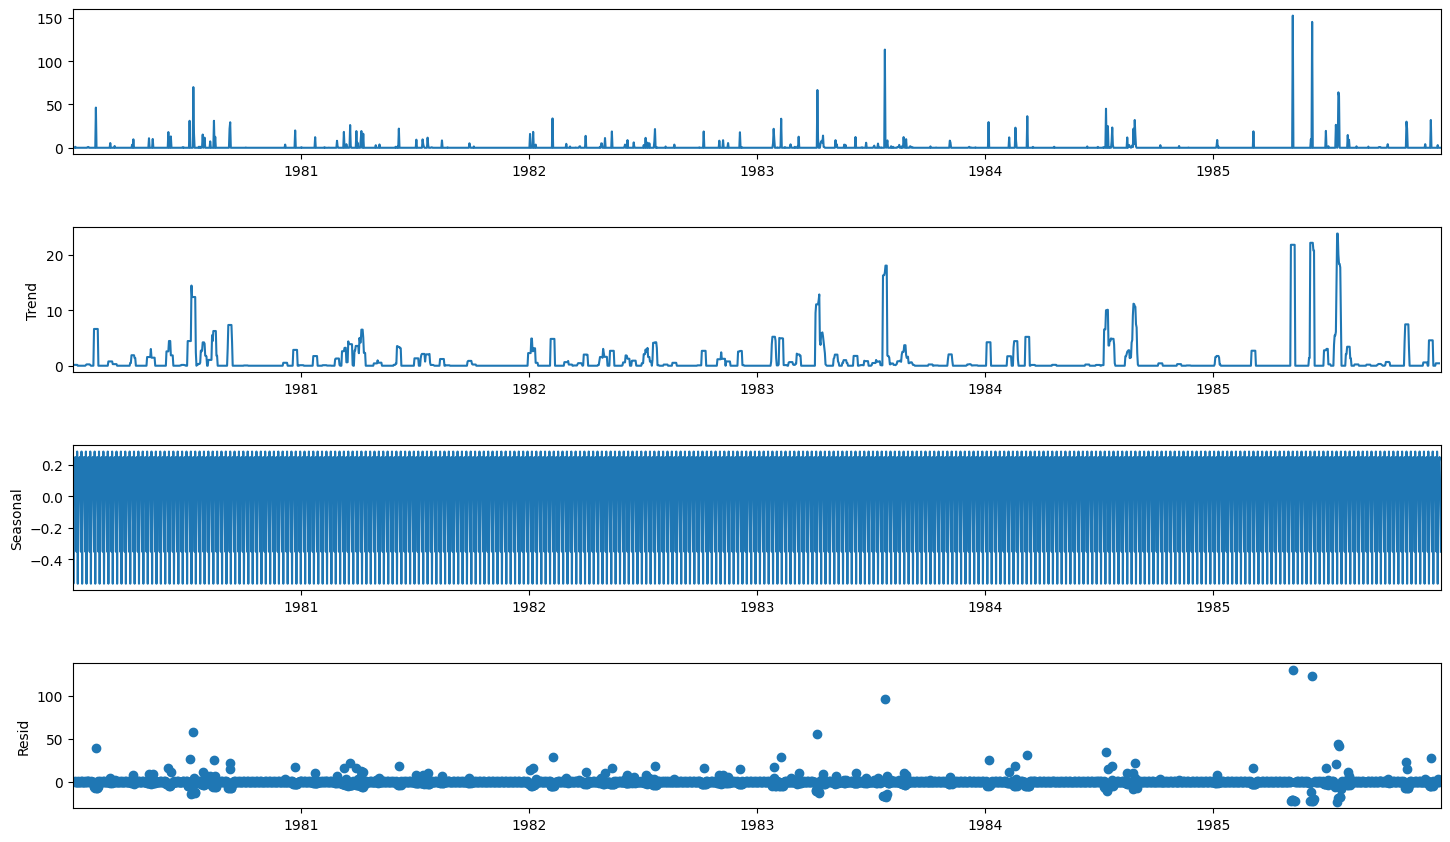

In [5]:
#we try to vizualie the trend and seasonality (code snippet taken from:https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861)
from statsmodels.tsa.seasonal import seasonal_decompose

data_for_analysis.set_index('date', inplace=True)
data_for_analysis.sort_index(inplace=True)
analysis = data_for_analysis[['rain']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="addative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot().set_size_inches((16, 9)); #reference for resizinghttps://stackoverflow.com/questions/70377351/statsmodels-api-tsa-seasonal-decompose-plot-figsize

We do the variable imputation


In [6]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(dataframe_vars)

dataframe_vars_imp=imp.transform(dataframe_vars)
dataframe_vars=pd.DataFrame(dataframe_vars_imp, columns =dataframe_vars.columns  )     #convert numpy array to dataframe
dataframe_vars

,omega_x,omega_y,omega,pr_wtr,rhum_x,rhum_y,rhum,slp,tmp_x,tmp_y,tmp,uwnd_x,uwnd_y,uwnd,vwnd_x,vwnd_y,vwnd,rain
0,-0.026003,-0.082003,-0.093002,11.029999,14.750000,8.75,45.75,101663.0,297.59998,286.63000,296.59998,22.910004,9.360001,1.600006,-0.649994,1.080002,0.430008,0.0
1,0.145998,0.091997,0.041998,7.760010,8.000000,9.75,16.25,102055.0,297.59998,283.83002,296.51000,20.330002,8.500015,0.750015,-6.569992,-2.739990,-0.819992,0.0
2,0.131998,0.095999,0.105997,7.980011,8.250000,13.25,15.75,102250.0,297.59998,281.63000,296.47998,15.280014,6.630005,-2.289993,-4.219986,-1.289993,-0.539993,0.0
3,0.019999,0.000998,0.022999,7.279999,8.000000,9.00,12.75,102155.0,297.59998,280.38000,296.40000,14.550003,6.580002,-1.389999,-1.089996,-1.199997,0.410004,0.0
4,0.183998,0.140999,0.069998,9.200012,16.250000,7.75,21.25,102288.0,297.59998,280.58002,296.30000,25.030014,8.880005,0.830002,-12.299988,-5.269989,-2.369995,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,0.028997,-0.045002,-0.071003,12.809998,17.750000,15.75,42.50,101460.0,297.59998,288.51000,296.63000,36.210007,15.760010,2.800003,-12.019989,-5.039993,-1.189987,0.0
2187,0.088999,0.090998,0.059998,15.380005,34.750000,44.50,24.50,101780.0,297.59998,285.96000,296.59998,31.350006,13.080002,0.950012,-1.689987,-3.149994,-3.939987,0.0
2188,0.006998,-0.082003,-0.125002,14.929993,10.000000,45.50,38.25,101885.0,297.59998,286.40000,296.55000,39.100006,17.110000,4.810013,2.360001,1.180008,0.260010,0.0
2189,0.147999,0.146997,0.107998,8.329987,15.250000,7.00,17.75,101998.0,297.59998,284.97998,296.51000,37.680008,12.730011,2.980011,-5.789993,-5.139984,-4.149994,0.0


We can check the correlation of each of the parameters with the rainfall data

In [7]:
corr=dataframe_vars.corrwith(dataframe_vars['rain']) #reference:https://stackoverflow.com/questions/70479605/python-pandas-pandas-correlation-one-column-vs-all
corr

omega_x   -0.157858
omega_y   -0.100193
omega     -0.137914
pr_wtr     0.222171
rhum_x     0.093496
rhum_y     0.120498
rhum       0.236154
slp       -0.125867
tmp_x           NaN
tmp_y      0.065789
tmp        0.102731
uwnd_x    -0.122291
uwnd_y    -0.118665
uwnd      -0.034077
vwnd_x     0.068491
vwnd_y     0.076591
vwnd       0.110636
rain       1.000000
dtype: float64

We plot it

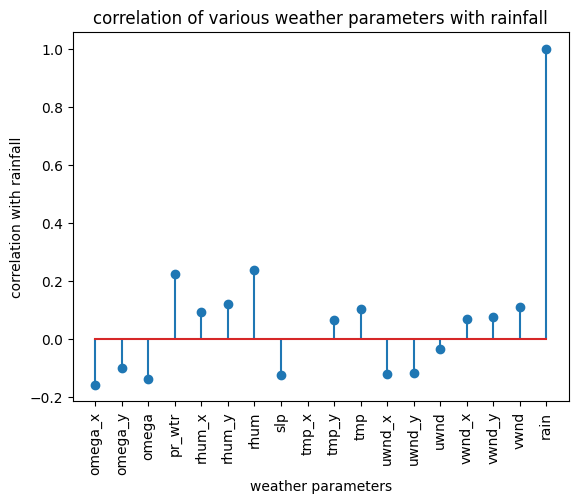

In [8]:
plt.stem(dataframe_vars.columns,corr)
plt.xlabel("weather parameters")
plt.ylabel("correlation with rainfall")
plt.title("correlation of various weather parameters with rainfall")
plt.xticks(rotation = 90)  #to rotate axis lables for vizualization reference:https://stackabuse.com/rotate-axis-labels-in-matplotlib/
plt.show()

We can drop the tmp_x variable as its giving impropoer correlation result

In [9]:
dataframe_vars=dataframe_vars[dataframe_vars.columns[~dataframe_vars.columns.isin(['tmp_x'])]]
dataframe_vars

,omega_x,omega_y,omega,pr_wtr,rhum_x,rhum_y,rhum,slp,tmp_y,tmp,uwnd_x,uwnd_y,uwnd,vwnd_x,vwnd_y,vwnd,rain
0,-0.026003,-0.082003,-0.093002,11.029999,14.750000,8.75,45.75,101663.0,286.63000,296.59998,22.910004,9.360001,1.600006,-0.649994,1.080002,0.430008,0.0
1,0.145998,0.091997,0.041998,7.760010,8.000000,9.75,16.25,102055.0,283.83002,296.51000,20.330002,8.500015,0.750015,-6.569992,-2.739990,-0.819992,0.0
2,0.131998,0.095999,0.105997,7.980011,8.250000,13.25,15.75,102250.0,281.63000,296.47998,15.280014,6.630005,-2.289993,-4.219986,-1.289993,-0.539993,0.0
3,0.019999,0.000998,0.022999,7.279999,8.000000,9.00,12.75,102155.0,280.38000,296.40000,14.550003,6.580002,-1.389999,-1.089996,-1.199997,0.410004,0.0
4,0.183998,0.140999,0.069998,9.200012,16.250000,7.75,21.25,102288.0,280.58002,296.30000,25.030014,8.880005,0.830002,-12.299988,-5.269989,-2.369995,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,0.028997,-0.045002,-0.071003,12.809998,17.750000,15.75,42.50,101460.0,288.51000,296.63000,36.210007,15.760010,2.800003,-12.019989,-5.039993,-1.189987,0.0
2187,0.088999,0.090998,0.059998,15.380005,34.750000,44.50,24.50,101780.0,285.96000,296.59998,31.350006,13.080002,0.950012,-1.689987,-3.149994,-3.939987,0.0
2188,0.006998,-0.082003,-0.125002,14.929993,10.000000,45.50,38.25,101885.0,286.40000,296.55000,39.100006,17.110000,4.810013,2.360001,1.180008,0.260010,0.0
2189,0.147999,0.146997,0.107998,8.329987,15.250000,7.00,17.75,101998.0,284.97998,296.51000,37.680008,12.730011,2.980011,-5.789993,-5.139984,-4.149994,0.0


In [10]:
#normalize columns except rain column https://stackoverflow.com/questions/28576540/how-can-i-normalize-the-data-in-a-range-of-columns-in-my-pandas-dataframe

# rain_min=dataframe_vars['rain'].min()
# rain_max=dataframe_vars['rain'].max()

# h=~dataframe_vars.columns.isin(['rain'])
# cols_to_normalize=dataframe_vars.columns[h]
# dataframe_vars[cols_to_normalize] = dataframe_vars[cols_to_normalize].apply(lambda x: (x - x.min()) / (x.max()-x.min()))
# rain_min,rain_max


Now we are ready for the multivariate Time series analysis, we will try LSTM

In [11]:
#we make this function in order to ensure that the inverse transform function gets proper input size(using a dummy matrix)
def get_inverse(data_array,func):
  dummy_array=np.random.random_sample((data_array.shape[0],dataset.shape[1]))
  dummy_array.astype(np.float64)
  for i in range(0,len(data_array-1)):
    dummy_array[i,16]=data_array[i]
#  print(trainPredict[i])


  dummy_inverse = func.inverse_transform(dummy_array)
  data_array=dummy_inverse[:,16]
  return data_array


**LSTM**

In [12]:
from sklearn.preprocessing import StandardScaler

def LSTM_multivariate(dataset_multi,sequence_length,lstm_1,lstm_2,lstm_3,dense_size):
  dataset = dataset_multi.values
  dataset = dataset.astype('float32') 

  dataset1 = dataset_multi.values
  dataset1 = dataset1.astype('float32') 


  sequence_length=sequence_length

  scaler = MinMaxScaler(feature_range=(0, 1)) 
  dataset = scaler.fit_transform(dataset)

# scalar1= MinMaxScaler(feature_range=(0, 1))
# dataset1 = scalar1.fit_transform(dataset1)



  train_data = dataset[0:round(0.66*len(dataset)), :]
  test_data = dataset[round(0.66*len(dataset)) - sequence_length:, :]

  def get_inverse(data_array,func):
    dummy_array=np.random.random_sample((data_array.shape[0],dataset.shape[1]))
    dummy_array.astype(np.float64)
    for i in range(0,len(data_array-1)):
      dummy_array[i,16]=data_array[i]
  #  print(trainPredict[i])


    dummy_inverse = func.inverse_transform(dummy_array)
    data_array=dummy_inverse[:,16]
    return data_array

    #Data preparation: Now for each training point we have F variables and S is sequence size, so the traiing point will be a matrix S x F , and training data size will be N x S x F

# code to split the data into train and test is taken from :https://github.com/flo7up/relataly-public-python-tutorials/blob/master/007%20Time%20Series%20Forecasting%20-%20Multivariate%20Time%20Series%20Models.ipynb

  def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, 16]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
  trainX, trainY = partition_dataset(sequence_length, train_data)
  testX, testY = partition_dataset(sequence_length, test_data)

  trainY=trainY.reshape(-1,1)
  testY=testY.reshape(-1,1)


  model = Sequential()
  model.add(LSTM(lstm_1, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) #return sequences should be true if stacking
  model.add(LSTM(lstm_2, activation='relu', return_sequences=True))
  model.add(LSTM(lstm_3, activation='relu', return_sequences=False)) 

  model.add(Dropout(0.2))
  model.add(Dense(dense_size))
  model.add(Dense(dense_size))
  model.add(Dense(trainY.shape[1]))

  model.compile(optimizer='adam', loss='mse')
  model.summary()

  

# make predictions

  mdl = model.fit(trainX, trainY, epochs=20)#,  validation_split=, verbose=1)

  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)




  trainPredict = get_inverse(trainPredict,scaler)
  trainY = get_inverse(trainY,scaler)
  testPredict = get_inverse(testPredict,scaler)
  testY = get_inverse(testY,scaler)
   
  

  

  # scaler1 = MinMaxScaler(feature_range=(trainY.min, trainY.max)) #Also try QuantileTransformer
  # trainPredict = scaler1.fit_transform(trainPredict)
  # testPredict = scaler1.fit_transform(testPredict)
  


  # calculate root mean squared error
  # trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
  print('Train Score: %.2f RMSE' % (trainScore))

  # testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  testScore = math.sqrt(mean_squared_error(testY, testPredict))
  print('Test Score: %.2f RMSE' % (testScore))

  

  
  return trainScore,testScore



In [13]:
# # dummy_array=np.random.uniform(10,size=(trainPredict.shape[0],dataset.shape[1]))
# dummy_array=np.random.random_sample((trainPredict.shape[0],dataset.shape[1]))
# dummy_array.astype(np.float64)
# for i in range(0,len(trainPredict-1)):
#  dummy_array[i,16]=trainPredict[i]
# #  print(trainPredict[i])


# dummy_inverse = scaler.inverse_transform(dummy_array)
# trainPredict=dummy_inverse[:,16]




# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=False))

# model.add(Dropout(0.2))
# model.add(Dense(10))
# model.add(Dense(trainY.shape[1]))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

LSTM_multivariate(dataframe_vars,10,128,128,128,10)





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           74752     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 1

(5.105651552919956, 9.112833475758025)

Now we can run and check the following trends:
1. Accuracy vs Sequence size
2. Accuracy vs LSTM units in a layer.
3. Accuracy vs number dense layers

In [14]:
#checking which sequence size is optimum

seqSize=[5,10,15,20,25]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  

  
  tr,tst = LSTM_multivariate(dataframe_vars,seq_size,128,128,128,10)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)







Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 128)            74752     
                                                                 
 lstm_4 (LSTM)               (None, 5, 128)            131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                

Train Score: 5.05 RMSE
Test Score: 9.05 RMSE


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 128)           74752     
                                                                 
 lstm_7 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 15, 128)           74752     
                                                                 
 lstm_10 (LSTM)              (None, 15, 128)           131584    
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 128)           74752     
                                                                 
 lstm_13 (LSTM)              (None, 20, 128)           131584    
                                                                 
 lstm_14 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 1)                

Train Score: 5.10 RMSE
Test Score: 9.07 RMSE


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 25, 128)           74752     
                                                                 
 lstm_16 (LSTM)              (None, 25, 128)           131584    
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                

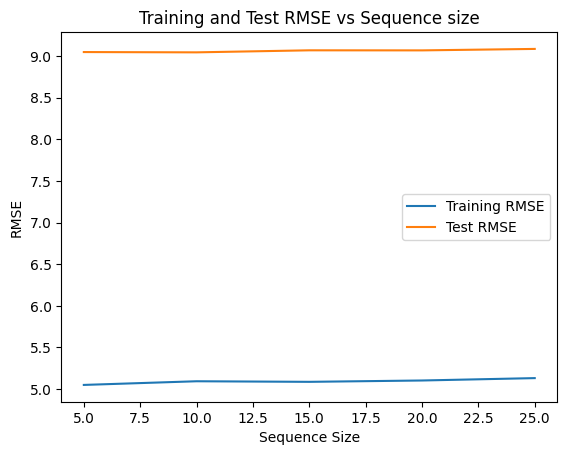

In [15]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE vs Sequence size")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()



In [16]:
#find index of minumum value in the list reference: https://www.adamsmith.haus/python/answers/how-to-find-the-index-of-the-minimum-value-of-a-list-in-python
min_val=min(seqSizeTestScore) #
best_seq_size= seqSize[seqSizeTestScore.index(min_val)]
best_seq_size #freeze this for nect experiments

10

In [17]:
##Find optimmum Number of LSTM units



LSTM_Units=[32,64,96,128]
UnitsTrainScore=[]
UnitsTestScore=[]


for i in LSTM_Units:
  no_of_units=i
  

  
  tr,tst = LSTM_multivariate(dataframe_vars,best_seq_size,no_of_units,no_of_units,no_of_units,10)
  UnitsTrainScore.append(tr)
  UnitsTestScore.append(tst)






Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 32)            6400      
                                                                 
 lstm_19 (LSTM)              (None, 10, 32)            8320      
                                                                 
 lstm_20 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 10)                330       
                                                                 
 dense_19 (Dense)            (None, 10)                110       
                                                                 
 dense_20 (Dense)            (None, 1)                

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 10, 64)            20992     
                                                                 
 lstm_22 (LSTM)              (None, 10, 64)            33024     
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 10)                650       
                                                                 
 dense_22 (Dense)            (None, 10)                110       
                                                                 
 dense_23 (Dense)            (None, 1)                

Train Score: 5.13 RMSE
Test Score: 9.13 RMSE


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10, 96)            43776     
                                                                 
 lstm_25 (LSTM)              (None, 10, 96)            74112     
                                                                 
 lstm_26 (LSTM)              (None, 96)                74112     
                                                                 
 dropout_8 (Dropout)         (None, 96)                0         
                                                                 
 dense_24 (Dense)            (None, 10)                970       
                                                                 
 dense_25 (Dense)            (None, 10)                110       
                                                                 
 dense_26 (Dense)            (None, 1)                

Train Score: 5.08 RMSE
Test Score: 9.02 RMSE


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 10, 128)           74752     
                                                                 
 lstm_28 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_29 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 10)                1290      
                                                                 
 dense_28 (Dense)            (None, 10)                110       
                                                                 
 dense_29 (Dense)            (None, 1)                

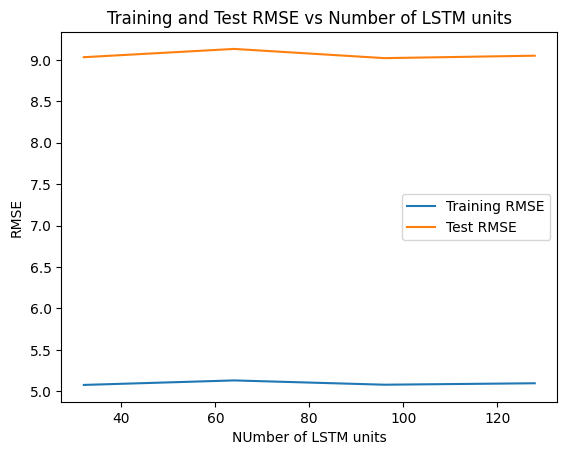

15

In [21]:
plt.plot(LSTM_Units,UnitsTrainScore)
plt.plot(LSTM_Units,UnitsTestScore)
plt.title("Training and Test RMSE vs Number of LSTM units")
plt.xlabel("NUmber of LSTM units")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

min_val=min(UnitsTestScore) #
best_no_of_units= seqSize[UnitsTestScore.index(min_val)]
best_no_of_units  #freeze this for next experiments

In [19]:
##Number of dense neurons of LSTM units



Dense_neurons=[5,10,15,20]
DenseTrainScore=[]
DenseTestScore=[]


for i in Dense_neurons:
  no_of_neurons=i
  

  
  tr,tst = LSTM_multivariate(dataframe_vars,best_seq_size,best_no_of_units,best_no_of_units,best_no_of_units,no_of_neurons)
  DenseTrainScore.append(tr)
  DenseTestScore.append(tst)




Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 10, 15)            1980      
                                                                 
 lstm_31 (LSTM)              (None, 10, 15)            1860      
                                                                 
 lstm_32 (LSTM)              (None, 15)                1860      
                                                                 
 dropout_10 (Dropout)        (None, 15)                0         
                                                                 
 dense_30 (Dense)            (None, 5)                 80        
                                                                 
 dense_31 (Dense)            (None, 5)                 30        
                                                                 
 dense_32 (Dense)            (None, 1)               

Train Score: 5.09 RMSE
Test Score: 9.05 RMSE


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 10, 15)            1980      
                                                                 
 lstm_34 (LSTM)              (None, 10, 15)            1860      
                                                                 
 lstm_35 (LSTM)              (None, 15)                1860      
                                                                 
 dropout_11 (Dropout)        (None, 15)                0         
                                                                 
 dense_33 (Dense)            (None, 10)                160       
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 1)               

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 10, 15)            1980      
                                                                 
 lstm_37 (LSTM)              (None, 10, 15)            1860      
                                                                 
 lstm_38 (LSTM)              (None, 15)                1860      
                                                                 
 dropout_12 (Dropout)        (None, 15)                0         
                                                                 
 dense_36 (Dense)            (None, 15)                240       
                                                                 
 dense_37 (Dense)            (None, 15)                240       
                                                                 
 dense_38 (Dense)            (None, 1)               

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 10, 15)            1980      
                                                                 
 lstm_40 (LSTM)              (None, 10, 15)            1860      
                                                                 
 lstm_41 (LSTM)              (None, 15)                1860      
                                                                 
 dropout_13 (Dropout)        (None, 15)                0         
                                                                 
 dense_39 (Dense)            (None, 20)                320       
                                                                 
 dense_40 (Dense)            (None, 20)                420       
                                                                 
 dense_41 (Dense)            (None, 1)               

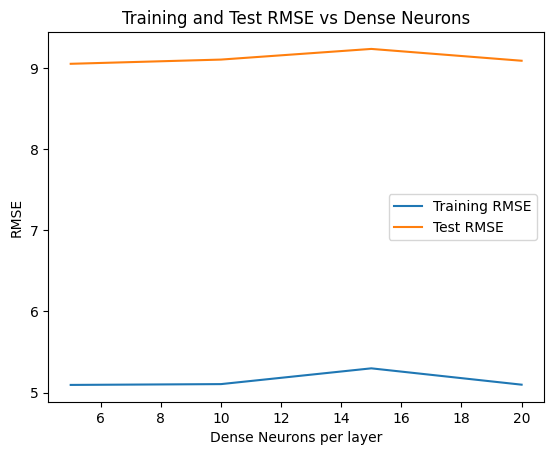

15

In [23]:
plt.plot(Dense_neurons,DenseTrainScore)
plt.plot(Dense_neurons,DenseTestScore)
plt.title("Training and Test RMSE vs Dense Neurons")
plt.xlabel("Dense Neurons per layer")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

min_val=min(UnitsTestScore) #
best_no_of_units= seqSize[UnitsTestScore.index(min_val)]
best_no_of_units

In [24]:
DenseTestScore

[9.050908581486757, 9.102923516294906, 9.234197323756455, 9.08860106291032]